# Train Llama2-7b for Abstractive Text Summarization

Install packages

In [1]:
!pip install datasets transformers matplotlib numpy -q
#!pip install torch
#!pip3 install Cython
!pip install ludwig ludwig[llm] -q

## Use this image Docker: PyTorch with cuda < 11.7

Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.


In [2]:
from IPython.display import HTML, display

def set_css():
    display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
    if torch.cuda.is_available():
        model = None
        torch.cuda.empty_cache()

In [3]:
import getpass
#import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
print("Torch version: ", torch.__version__)
print("Cuda is available: ", torch.cuda.is_available())
print(torch.version.cuda)

Torch version:  2.0.0
Cuda is available:  True
11.7


Put the notebook in a logging mode so we can save the output to a file. This is useful for debugging and sharing the results of the notebook. The log file will be saved in the same directory as the notebook. 

In [6]:
import sys
import logging

nblog = open("nb-ludwig-llm.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5


Autosaving every 5 seconds


## Load datasets from HuggingFace data - XSum

In [7]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset("xsum")

Show random elements

In [8]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))


show_random_elements(raw_datasets["train"])

In [14]:
summary_series = [
    pd.Series(raw_datasets["train"]["summary"]),
    pd.Series(raw_datasets["validation"]["summary"]),
    pd.Series(raw_datasets["test"]["summary"])
]

document_series = [
    pd.Series(raw_datasets["train"]["document"]),
    pd.Series(raw_datasets["validation"]["document"]),
    pd.Series(raw_datasets["test"]["document"])
]

summary = pd.concat(summary_series)
document = pd.concat(document_series)

In [15]:
d = {'instruction': document, 'input': None, 'output': summary}
df = pd.DataFrame(data=d)
df

,instruction,input,output
0,The ex-Reading defender denied fraudulent trad...,None,Former Premier League footballer Sam Sodje has...
1,Voges was forced to retire hurt on 86 after su...,None,Middlesex batsman Adam Voges will be out until...
2,Seven photographs taken in the Norfolk country...,None,The Duchess of Cambridge will feature on the c...
3,"Chris Poole - known as ""moot"" online - created...",None,Google has hired the creator of one of the web...
4,Four police officers were injured in the incid...,None,Two teenagers have been charged in connection ...
...,...,...,...
11329,Amnesty International supporters are zipped in...,None,Two hundred body bags have been placed on Brig...
11330,The project was launched in Grenada by the pri...,None,Budding hospitality workers from the Caribbean...
11331,The world number two won 6-2 6-0 in 66 minutes...,None,Britain's Andy Murray is through to the Monte ...
11332,Mr Pistorius says he mistakenly shot his girlf...,None,A forensics expert has swung a cricket bat at ...


In [16]:
import numpy as np
# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

np.random.shuffle(split_values)
df['split'] = split_values
df['split'] = df['split'].astype(int)


In [17]:
df.head(10)

,instruction,input,output,split
0,The ex-Reading defender denied fraudulent trad...,None,Former Premier League footballer Sam Sodje has...,0
1,Voges was forced to retire hurt on 86 after su...,None,Middlesex batsman Adam Voges will be out until...,0
2,Seven photographs taken in the Norfolk country...,None,The Duchess of Cambridge will feature on the c...,0
3,"Chris Poole - known as ""moot"" online - created...",None,Google has hired the creator of one of the web...,0
4,Four police officers were injured in the incid...,None,Two teenagers have been charged in connection ...,0
5,The injured pedestrian - a young man - is thou...,None,A pedestrian has been struck by a taxi in Dund...,0
6,Barca will be investigated for alleged misappr...,None,Barcelona football club chief Sandro Rosell ha...,0
7,"The think tank said the city's 1,536 schools n...",None,About 70% of London schools could face budget ...,0
8,His 110 means he has scored 323 runs in a week...,None,Jason Roy continued his fine form with a secon...,0
9,Ms Kendall told the BBC Labour risked sending ...,None,Labour leadership hopefuls Liz Kendall and Yve...,0


Average number of tokens in the input column: 731
Average number of tokens in the output column: 42


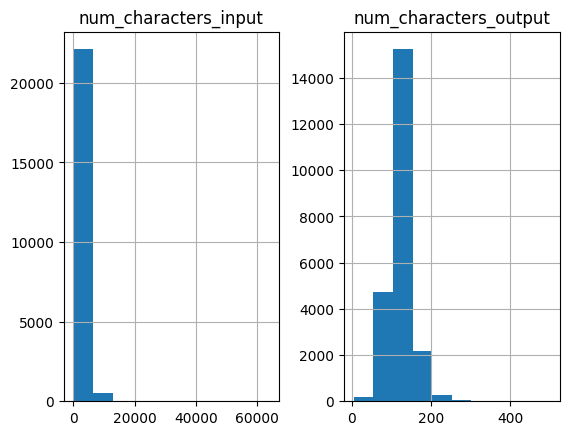

In [19]:
# Calculating the length of each cell in each column
df['num_characters_input'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=[ 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

### **Setup Your HuggingFace Token** 🤗

We'll be exploring Llama-2 today, which a model released by Meta. However, the model is not openly-accessible and requires requesting for access (assigned to your HuggingFace token).

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) and request access to [Llama2-7b-hf](https://huggingface.co/meta-llama/Llama-2-7b-hf) before proceeding. You may need to signup on HuggingFace if you don't aleady have an account: https://huggingface.co/join

Incase you haven't been given access to Llama-2-7b, that is alright. We can just use Llama-1 for the rest of this example: [huggyllama/llama-7b](https://huggingface.co/huggyllama/llama-7b).

In [20]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token: ········



Training Llama-2-7b model for text summarization
---
There are three different fine-tuning approaches in Ludwig:

1. **Full Fine-Tuning**:

- Involves training the entire pre-trained model on new data from scratch.
- All model layers and parameters are updated during fine-tuning.
- Can lead to high accuracy but requires a significant amount of computational resources and time.
- Runs the risk of catastrophic forgetting: occasionally, since we are updating all of the weights in the model, this process can lead to the algorithm inadvertently losing knowledge of its past tasks, i.e., the knowledge it gained during pretraining. The outcome may vary, with the algorithm experiencing heightened error margins in some cases, while in others, it might completely erase the memory of a specific task leading to terrible performance.
- Best suited when the target task is significantly different from the original pre-training task.

2. **Parameter Efficient Fine-Tuning (PEFT), e.g. LoRA**:

- Focuses on updating only a subset of the model's parameters.
- Often involves freezing certain layers or parts of the model to avoid catastrophic forgetting, or inserting additional layers that are trainable while keeping the original model's weights frozen.
- Can result in faster fine-tuning with fewer computational resources, but might sacrifice some accuracy compared to full fine-tuning.
- Includes methods like LoRA, AdaLoRA and Adaption Prompt (LLaMA Adapter)
- Suitable when the new task shares similarities with the original pre-training task.

3. **Quantization-Based Fine-Tuning (QLoRA)**:

- Involves reducing the precision of model parameters (e.g., converting 32-bit floating-point values to 8-bit or 4-bit integers). This reduces the amount of CPU and GPU memory required by either 4x if using 8-bit integers, or 8x if using 4-bit integers.
- Typically, since we're changing the weights to 8 or 4 bit integers, we will lose some precision/performance.
- This can lead to reduced memory usage and faster inference on hardware with reduced precision support.
- Particularly useful when deploying models on resource-constrained devices, such as mobile phones or edge devices.


**Today, we're going to fine-tune using method 3 since we only have access to a single T4 GPU with 16GiB of GPU VRAM on Colab.** If you have more compute available, give LoRA based fine-tuning or full fine-tuning a try! Typically this requires 4 GPUs with 24GiB of GPU VRAM on a single node multi-GPU cluster and fine-tuning Deepspeeed.


To do this, the new parameters we're introducing are:

- `adapter`: The PEFT method we want to use
- `quantization`: Load the weights in int4 or int8 to reduce memory overhead.
- `trainer`: We enable the `finetune` trainer and can configure a variety of training parameters such as epochs and learning rate.


In [21]:
#meta-llama/Llama-2-7b-hf
#prompt:
#  template: >-
#    Below is an instruction that describes a task, paired with an input
#    that provides further context. Write a response that appropriately
#    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:


The model is available from huggingface: meta-llama/Llama-2-7b-hf
If you want to use Llama-2-7b, you will need to request access to the model from HuggingFace and Meta.

We will use huggyllama/llama-7b for this example since it is publicly available.

In [22]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: huggyllama/llama-7b

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text


generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.00001
  optimizer:
    type: adam
    params:
      eps: 1.e-8
      betas:
        - 0.9
        - 0.999
      weight_decay: 0
  learning_rate_scheduler:
    warmup_fraction: 0.03
    reduce_on_plateau: 0
"""
)




In [23]:
%%time  
model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)


╒════════════════════════╕
│ EXPERIMENT DESCRIPTION │
╘════════════════════════╛

╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /results/api_experiment_run_5                                                           │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ ludwig_version   │ '0.8.1.post1'                                                                           │
├──────────────────┼─────────

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
No padding token id found. Using eos_token as pad_token.
Max length of feature 'instruction': 2048 (without start and stop symbols)
Setting max length using dataset: 2050 (including start and stop symbols)
Truncating max length with max_sequence_length=256 from preprocessing parameters
max sequence length is 256 for feature 'instruction'
Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
No padding token id found. Using eos_token as pad_token.
Max length of feature 'output': 122 (without start and stop symbols)
Setting max length using dataset: 124 (including start and stop symbols)
max sequence length is 124 for feature 'output'
Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
No padding token id found. Using eos_token as pad_token.
Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
No padding token id found. Using eos_token as pad_token.
Building dataset: DONE
Writing 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Done.
Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
No padding token id found. Using eos_token as pad_token.
Trainable Parameter Summary For Fine-Tuning
Fine-tuning with adapter: lora
trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199

╒══════════╕
│ TRAINING │
╘══════════╛

Creating fresh model training run.
Training for 79335 step(s), approximately 5 epoch(s).
Early stopping policy: 5 round(s) of evaluation, or 79335 step(s), approximately 5 epoch(s).

Starting with step 0, epoch: 0
Training:  20%|██        | 15867/79335 [1:14:25<11:50:53,  1.49it/s]
Running evaluation for step: 15867, epoch: 1
Evaluation test : 100%|██████████| 2267/2267 [1:52:33<00:00,  2.98s/it]
Evaluation took 2h 48m 32.9370s

╒════════════╤═══════════════════╤════════╤═════════════════════════╤══════════════╤═════════════════════╤══════════════════╕
│ output     │   char_error_rate │   loss │   next_token_perplexity │   perplexity │   sequence_accurac

## Generate predictions

In [26]:
test_examples = pd.DataFrame([
      {
            "instruction": """One Piece is one of the most daunting anime one could start watching. It began when mangaka, Eiichiro Oda, started publishing One Piece in Weekly Shonen Jump’s manga magazine in 1997. It would get a quick anime adaption that started airing in 1999, and it became known as one of Shonen Jump’s “Big Three,” the most popular titles in the magazine, alongside Bleach and Naruto. Roughly a decade after the term the Big Three was coined, One Piece is the only manga and anime still running with weekly manga chapters and anime episodes.
            One Piece is the story of Monkey D. Luffy, a young man who has a single dream: To find the legendary treasure known as the One Piece and become the King of the Pirates. Alongside a crew of trusted friends, Luffy sails the dangerous seas of the Grand Line to find Laugh Tale, the hidden island containing the One Piece. On his journey, Luffy faces many dangerous foes, including fellow pirates who want to conquer the seas, and the Navy who want to purge the world of the pirate menace.
            With over a thousand published chapters and nearly as many anime episodes, One Piece has gathered an immense cast of characters, two rich magic systems, and a depth of lore across many diverse locales. This depth can make it hard for new viewers to jump into the anime or the manga, and this article will get you started by explaining the two magic systems: Devil Fruits and Haki.Of the two magic systems, Devil Fruits are the oldest and perhaps one of Oda’s greatest creations in the entire manga. Introduced at the beginning of the story, Devil Fruits have always been a vital part of One Piece’s frequent spectacular battles. Devil Fruits are incredibly rare and distinctive fruits that grant anyone who eats a single bite incredible powers. The fruits are easily identifiable, thanks to their vibrant colors, an intricate pattern of swirls on their skin, and by their foul taste. No two Devil Fruits grant the same power, but all Devil Fruit eaters share two weaknesses: The ocean and Sea Prism Stone.All Devil Fruit eaters lose their ability to swim after consuming the Devil Fruit. It’s not just a loss of muscle memory; entering a body of water saps them of all energy. Even entering a bath can drain a Devil Fruit eater of energy and prevent them from using their abilities. Notably, it does need to be a body of water. Simply spilling a glass of water on them or spraying them with a hose wouldn’t have the same effect. One Piece is an anime about pirates sailing the high seas, making this an especially devastating weakness. One poor battle on the ocean can send a Devil Fruit eater to their death, or even just a patch of rough water. It’s currently unknown why Devil Fruit eaters can’t swim. One explanation is because the ocean hates those with Devil Fruit powers, but it’s unclear if this is the truth or one of the many myths that have grown around the Fruits over the centuries.Sea Prism Stone is known as a stone that has the same properties as the ocean. When a Devil Fruit eater touches Sea Prism Stone, it provokes a response very similar to being dropped in the ocean, draining them of their energy and preventing them from using their powers. The Sea Prism Stone is also impervious to any Devil Fruit powers used on it.
            Sea Prism Stone is most commonly used to build cuffs and chains that bind Devil Fruit users, keeping them lethargic and powerless for easy capture and detainment. However, it has several other applications; offensively, the Navy makes bullets and nets from it to capture Devil Fruit eaters easier. The Navy has also been known to line the bottoms of their ships with the Stone to deter violent ocean life from attacking them. The Devil Fruits are central to One Piece’s appeal by offering a wild variety of abilities that help keep battles interesting while showing off Oda’s immense creative abilities. One hallmark of Devil Fruits is that they’re only as powerful as the user, offering greater strength to those willing to test the limits of their power and use their minds as well as their fists. While no two Devil Fruits grant the same abilities, they are grouped into three classes: Zoan, Logia, and Paramecia.Zoan-type fruits offer their users the ability to transform and shapeshift, most often into some form of animal, though a member of Luffy's crew, Chopper is a reindeer who ate the Human-Human Fruit. Most Zoan users gain access to several transformations that range from completely human to completely bestial, though they retain their human minds regardless of their form. Zoan-types can be further divided into two especially rare subclasses: Mythical and Ancient. Mythical Zoan-types allow their users to become creatures straight from myths and legends. A great example of a mythical Zoan Fruit is the one possessed by Kaido, a fearsome villain who’s known as a Yonko, one of the Four Emperors of the Sea. Kaido’s Fish-Fish Fruit: Azure Dragon Model allows him to become a massive dragon, allowing Kaido to uphold his reign of terror in the New World Ancient-type Zoan Fruits allow their users to become long-extinct creatures like dinosaurs, such as X Drake’s Dragon-Dragon Fruit: Allosaurus Model that allows him to become a powerful allosaurus. Mythical and ancient Zoan Fruits are immensely rare compared to average Zoan types, and even Devil Fruits in general and are considered stronger than ordinary Zoan like Chopper’s Human-Human Fruit.Logia-type Devil Fruits are the rarest and most powerful type of Devil Fruit. They grant elemental-based powers, including the four elements of fire, water, earth, and air most Western audiences will be familiar with. While some of the Fruits grant one of these directly, such as the Flare-Flare Fruit that grants fire-based abilities, they also offer unique ways of using them. Both the Gas-Gas Fruit and the Smoke-Smoke Fruit involve air-based powers but have very different uses. All Logia-types allow their users to generate infinite amounts of their element, giving them extremely powerful offensive capabilities. The true strength of Logia-type fruits, however, lies in how they make the eater a part of that element. Logia-type users are incredibly hard to harm, with many of them being incorporeal. For example, one of protagonist Luffy’s greatest rivals is Navy Vice Admiral Smoker, who ate the Smoke-Smoke Fruit. Trying to strike Smoker without Sea Prism Stone or Haki is like trying to punch a pile of smoke - completely ineffective. Logia-types can also make part or all of their bodies into their element, giving them a variety of ways to manipulate their environment and attack. The combination of offense and defense capabilities is what makes Logia-type users such dangerous foes.Paramecia-type Devil Fruits are the most common type of Devil Fruit and offer a wide range of abilities, acting as a catch-all for fruits that don’t allow animal transformation or element-based powers. However, they are sorted into three groups: Body manipulation, environmental manipulation, and substance generation. The best example of body manipulation Paramecia lies in the protagonist, Luffy. After eating the Gum-Gum Fruit, Luffy became a rubber person - his body is incredibly stretchy and resistant to many physical-based attacks because he bounces back. His body always has the same properties as rubber. Other body manipulation fruits work on command, such as the Weapon-Weapon Fruit that allows its user to turn their arms and legs into various weapons.
            Environmental manipulation Fruits let their users dramatically alter the environment around them, working on either inanimate objects, living objects, or both. An especially powerful environmental manipulation fruit is the Ope-Ope Fruit, possessed by Trafalgar Law. Law can create an environment called a “Room” around him in a sphere and can manipulate anything within his sphere as he pleases, living or not. Finally, substance-generating Paramecia-types can appear similar to Logia-types. Users with this kind of fruit are capable of producing infinite amounts of a substance and manipulating it to their will, but they are not made of it the way a Logia-type user is. An example of this Devil Fruit is the String-String Fruit possessed by the villain, Doflamingo. Doflamingo can produce incredibly strong, sharp strings for a variety of purposes such as flying and attacking, but he’s unable to make his body into strings; any blows against him will strike normally.Haki is the second magic system introduced in One Piece. Haki wasn’t properly introduced until the Marineford Arc, just before a two-year time skip that theoretically marks the halfway point of One Piece, but it was hinted at several times before this arc. Haki is a way of utilizing a person’s spiritual energy in offensive or defensive manners. Unlike Devil Fruit powers, which are only obtainable by consuming the rare Fruits, any living person is capable of awakening their Haki though the vast majority of people go their entire lives without knowing it even exists. There are three major types of Haki: Observational, Armament, and Conqueror’s."
            """
      },
      {
            "instruction": """One of the main differences between humans and computers is that humans learn from past experiences, at least they try, but computers or machines need to be told what to do. Computers are strict logic machines with zero common sense. That means if we want them to do something, we have to provide them with detailed, step-by-step instructions on exactly what to do. So we write scripts and programmed computers to follow those instructions. That’s where Machine Learning comes in. Machine learning Concept consists of getting computers to learn from experiences-past data. What is Machine Learning? The following content was initially published on Quora as response to a question: What is machine learning? by Sheetal Rani Babu Machine learning is an application of artificial intelligence (AI) that provides systems the ability to automatically learn and improve from experience without being explicitly programmed. Machine learning focuses on the development of computer programs that can access data and use it to learn for themselves. The process of learning begins with observations or data, such as examples, direct experience, or instruction, in order to look for patterns in data and make better decisions in the future based on the examples that we provide. The primary aim is to allow the computers to learn automatically without human intervention or assistance and adjust actions accordingly. Machine learning algorithms are often categorized as supervised or unsupervised. Supervised Machine Learning algorithms It can apply what has been learned in the past to new data using labeled examples to predict future events. Starting from the analysis of a known training dataset, the learning algorithm produces an inferred function to make predictions about the output values. Unsupervised Machine Learning algorithms In contrast, unsupervised machine learning algorithms are used when the information used to train is neither classified nor labeled. Unsupervised learning studies how systems can infer a function to describe a hidden structure from unlabeled data. Semi-supervised machine learning algorithms fall somewhere in between supervised and unsupervised learning since they use both labeled and unlabeled data for training — typically a small amount of labeled data and a large amount of unlabeled data. The systems that use this method are able to considerably improve learning accuracy. Reinforcement machine learning algorithm is a learning method that interacts with its environment by producing actions and discovers errors or rewards. Trial and error search and delayed reward are the most relevant characteristics of reinforcement learning. This method allows machines and software agents to automatically determine the ideal behavior within a specific context in order to maximize its performance. Machine learning is being used in a wide range of applications today. One of the most well-known examples is Facebook’s News Feed. The News Feed uses machine learning to personalize each member’s feed. If a member frequently stops scrolling to read or like a particular friend’s posts, the News Feed will start to show more of that friend’s activity earlier in the feed. Behind the scenes, the software is simply using statistical analysis and predictive analytics to identify patterns in the user’s data and use those patterns to populate the News Feed. Should the member no longer stop to read, like or comment on the friend’s posts, that new data will be included in the data set and the News Feed will adjust accordingly. Machine learning is also entering an array of enterprise applications. Customer relationship management (CRM) systems use learning models to analyze email and prompt sales team members to respond to the most important messages first. More advanced systems can even recommend potentially effective responses. Business intelligence (BI) and analytics vendors use machine learning in their software to help users automatically identify potentially important data points. Human resource (HR) systems use learning models to identify characteristics of effective employees and rely on this knowledge to find the best applicants for open positions. """
      },
      {
            "instruction": """
            Napoleon Bonaparte (born Napoleone Buonaparte;[a] 15 August 1769 – 5 May 1821), later known by his regnal name Napoleon I, was a French military commander and political leader who rose to prominence during the French Revolution and led successful campaigns during the Revolutionary Wars. He was the leader of the French Republic as First Consul from 1799 to 1804, then of the French Empire as Emperor of the French from 1804 until 1814 and again in 1815. Napoleons political and cultural legacy endures as a celebrated and controversial leader. He initiated many liberal reforms that have persisted, and is considered one of the greatest military commanders in history. His campaigns are still studied at military academies worldwide. Between three and six million civilians and soldiers died in the Napoleonic Wars.[2][3] Napoleon was born on the island of Corsica to a native family descending from Italian nobility.[4][5] He supported the French Revolution in 1789 while serving in the French army, and tried to spread its ideals to his native Corsica. He rose rapidly after he saved the governing French Directory by firing on royalist insurgents. In 1796, he began a military campaign against the Austrians and their Italian allies, scoring decisive victories and became a national hero. Two years later, he led a military expedition to Egypt that served as a springboard to political power. He engineered a coup in November 1799 and became First Consul of the Republic. In 1804, to consolidate and expand his power, he crowned himself Emperor of the French. Differences with the United Kingdom meant France faced the War of the Third Coalition by 1805. Napoleon shattered this coalition with victories in the Ulm campaign and at the Battle of Austerlitz, which led to the dissolution of the Holy Roman Empire. In 1806, the Fourth Coalition took up arms against him. Napoleon defeated Prussia at the battles of Jena and Auerstedt, marched the Grande Armée into Eastern Europe, and defeated the Russians in June 1807 at Friedland, forcing the defeated nations of the Fourth Coalition to accept the Treaties of Tilsit. Two years later, the Austrians challenged the French again during the War of the Fifth Coalition, but Napoleon solidified his grip over Europe after triumphing at the Battle of Wagram. Hoping to extend the Continental System, his embargo against Britain, Napoleon invaded the Iberian Peninsula and declared his brother Joseph the King of Spain in 1808. The Spanish and the Portuguese revolted in the Peninsular War aided by a British army, culminating in defeat for Napoleons marshals. Napoleon launched an invasion of Russia in the summer of 1812. The resulting campaign witnessed the catastrophic retreat of Napoleons Grande Armée. In 1813, Prussia and Austria joined Russian forces in a Sixth Coalition against France, resulting in a large coalition army defeating Napoleon at the Battle of Leipzig. The coalition invaded France and captured Paris, forcing Napoleon to abdicate in April 1814. He was exiled to the island of Elba, between Corsica and Italy. In France, the Bourbons were restored to power. Napoleon escaped in February 1815 and took control of France.[6] The Allies responded by forming a Seventh Coalition, which defeated Napoleon at the Battle of Waterloo in June 1815. The British exiled him to the remote island of Saint Helena in the Atlantic, where he died in 1821 at the age of 51. Napoleon had an extensive impact on the modern world, bringing liberal reforms to the lands he conquered, especially the regions of the Low Countries, Switzerland, and parts of modern Italy and Germany. He implemented many liberal policies in France and Western Europe.[b] Napoleons family was of Italian origin. His paternal ancestors, the Buonapartes, descended from a minor Tuscan noble family that emigrated to Corsica in the 16th century and his maternal ancestors, the Ramolinos, descended from a minor Genoese noble family.[13] His parents Carlo Maria di Buonaparte and Maria Letizia Ramolino maintained an ancestral home called Casa Buonaparte in Ajaccio. Napoleon was born there on 15 August 1769. He was the familys fourth child and third son.[c] He had an elder brother, Joseph, and younger siblings Lucien, Elisa, Louis, Pauline, Caroline, and Jérôme. Napoleon was baptised as a Catholic, under the name Napoleone.[14] In his youth, his name was also spelled as Nabulione, Nabulio, Napolionne, and Napulione.[15] Napoleon was born one year after the Republic of Genoa ceded Corsica to France.[16] The state sold sovereign rights a year before his birth and the island was conquered by France during the year of his birth. It was formally incorporated as a province in 1770, after 500 years under Genoese rule and 14 years of independence.[d] Napoleons parents joined the Corsican resistance and fought against the French to maintain independence, even when Maria was pregnant with him. His father Carlo was an attorney who had supported and actively collaborated with patriot Pasquale Paoli during the Corsican war of independence against France;[5] after the Corsican defeat at Ponte Novu in 1769 and Paolis exile in Britain, Carlo began working for the new French government and in 1777 was named representative of the island to the court of Louis XVI.[5][20] The dominant influence of Napoleons childhood was his mother, whose firm discipline restrained a rambunctious child.[20] Later in life, Napoleon said, The future destiny of the child is always the work of the mother.[21] His maternal grandmother had married into the Swiss Fesch family in her second marriage, and Napoleons uncle, the cardinal Joseph Fesch, fulfilled a role as protector of the Bonaparte family for some years. Napoleons noble, moderately affluent background afforded him greater opportunities to study than were available to a typical Corsican of the time.[22] When he turned 9 years old,[23][24] he moved to the French mainland and enrolled at a religious school in Autun in January 1779. In May, he transferred with a scholarship to a military academy at Brienne-le-Château.[25] In his youth he was an outspoken Corsican nationalist and supported the states independence from France.[23][26] Like many Corsicans, Napoleon spoke and read Corsican (as his mother tongue) and Italian (as the official language of Corsica).[27][28][29][26] He began learning French in school at around age 10.[30] Although he became fluent in French, he spoke with a distinctive Corsican accent and never learned to spell in French.[31] Consequently, Napoleon was routinely bullied by his peers for his accent, birthplace, short stature, mannerisms, and inability to speak French quickly.[28] He became reserved and melancholy, applying himself to reading. An examiner observed that Napoleon has always been distinguished for his application in mathematics. He is fairly well acquainted with history and geography ... This boy would make an excellent sailor.[e][33] One story told of Napoleon at the school is that he led junior students to victory against senior students in a snowball fight, showing his leadership abilities.[34] In early adulthood, Napoleon briefly intended to become a writer; he authored a history of Corsica and a romantic novella.[23] On completion of his studies at Brienne in 1784, Napoleon was admitted to the École Militaire in Paris. He trained to become an artillery officer and, when his fathers death reduced his income, was forced to complete the two-year course in one year.[35] He was the first Corsican to graduate from the École Militaire.[35] He was examined by the famed scientist Pierre-Simon Laplace.[36] Upon graduating in September 1785, Bonaparte was commissioned a second lieutenant in La Fère artillery regiment.[f][25] He served in Valence and Auxonne until after the outbreak of the French Revolution in 1789. Bonaparte was a fervent Corsican nationalist during this period.[38] He asked for leave to join his mentor Pasquale Paoli, when Paoli was allowed to return to Corsica by the National Assembly. But Paoli had no sympathy for Napoleon, as he deemed his father a traitor for having deserted the cause of Corsican independence.[39] He spent the early years of the Revolution in Corsica, fighting in a complex three-way struggle among royalists, revolutionaries, and Corsican nationalists. Napoleon embraced the ideals of the Revolution, becoming a supporter of the Jacobins and joining the pro-French Corsican Republicans who opposed Paolis policy and his aspirations to secede.[40] He was given command over a battalion of volunteers and promoted to captain in the regular army in 1792, despite exceeding his leave of absence and leading a riot against French troops.[41] When Corsica declared formal secession from France and requested the protection of the British government, Napoleon and his commitment to the French Revolution came into conflict with Paoli, who had decided to sabotage the Corsican contribution to the Expédition de Sardaigne by preventing a French assault on the Sardinian island La Maddalena.[42] Bonaparte and his family were compelled to flee to Toulon on the French mainland in June 1793 because of the split with Paoli.[43] Although he was born Napoleone Buonaparte, it was after this that Napoleon began styling himself Napoléon Bonaparte. His family did not drop the name Buonaparte until 1796. The first known record of him signing his name as Bonaparte was at the age of 27 (in 1796).[44][14][45] In July 1793, Bonaparte published a pro-republican pamphlet, Le souper de Beaucaire (Supper at Beaucaire), which gained him the support of Augustin Robespierre, the younger brother of the Revolutionary leader Maximilien Robespierre. With the help of his fellow Corsican Antoine Christophe Saliceti, Bonaparte was appointed senior gunner and artillery commander of the republican forces that arrived at Toulon on 8 September.[46][47] He adopted a plan to capture a hill where republican guns could dominate the citys harbour and force the British to evacuate. The assault on the position led to the capture of the city, and during it Bonaparte was wounded in the thigh on 16 December. Catching the attention of the Committee of Public Safety, he was put in charge of the artillery of France Army of Italy.[48] On 22 December he was on his way to a new post in Nice, promoted from colonel to brigadier general at the age of 24. He devised plans to attack the Kingdom of Sardinia as part of Frances campaign against the First Coalition.The French army carried out Bonapartes plan in the Battle of Saorgio in April 1794, and then advanced to seize Ormea in the mountains. From Ormea, it headed west to outflank the Austro-Sardinian positions around Saorge. After this campaign, Augustin Robespierre sent Bonaparte on a mission to the Republic of Genoa to determine that countrys intentions towards France.[49]
            """
      },
])



In [28]:
predictions = model.predict(test_examples)[0]
for input_with_prediction in zip(test_examples['instruction'], predictions['output_response']):
  #print(f"Instruction: {input_with_prediction[0]}")
  #print(f"Input: {input_with_prediction[1]}")
  print(f"Generated Output: {input_with_prediction[1][0]}")
  print("\n\n")

Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
No padding token id found. Using eos_token as pad_token.
Prediction:   0%|          | 0/1 [00:00<?, ?it/s]For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 512,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

Decoded text inputs for the first example in batch: <s>one piece is one of the most daunting anime one could start watching. it began when mangaka, eiichiro oda, started publishing one piece in weekly shonen jump’s manga magazine in 1997. it would get a quick anime adaption that started airing in 1999, and it became known as one of shonen jump’s “big three,” the most popular titles in the magazine, alongside bleach and naruto. roughly a decade after the term the big three was coined, one piece is the only manga and anime still running with weekly manga chapters and anime episodes.
            one piece is the story of monkey d. luffy, a young man who has a single dre

## Upload HuggingFace

In [ ]:
!ludwig upload hf_hub --repo_id thekenken/ludwig-llama7b-summarization --model_path /results/api_experiment_run_5